# <center> Тема 5. Композиции алгоритмов, случайный лес</center>
## <center> Часть 1. Bagging</center>

Из прошлых лекций вы уже узнали про разные алгоритмы классификации, а также научились правильно валидироваться и оценивать качество модели. Но что делать, если вы уже нашли лучшую модель и повысить точность модели больше не можете? В таком случае нужно применить более продвинутые техники машинного обучения, которые можно объединить словом «ансамбли». Ансамбль — это некая совокупность, части которой образуют единое целое. Из повседневной жизни вы знаете музыкальные ансамбли, где объединены несколько музыкальных инструментов, архитектурные ансамбли с разными зданиями и т.д. 

### Ансамбли

Хорошим примером ансамблей считается теорема Кондорсе «о жюри присяжных» (1784). Если каждый член жюри присяжных имеет независимое мнение, и если вероятность правильного решения члена жюри больше 0.5, то тогда вероятность правильного решения присяжных в целом возрастает с увеличением количества членов жюри и стремится к единице. Если же вероятность быть правым у каждого из членов жюри меньше 0.5, то вероятность принятия правильного решения присяжными в целом монотонно уменьшается и стремится к нулю с увеличением количества присяжных. 
- $\large N $ — количество присяжных
- $\large p $ — вероятность правильного решения присяжного
- $\large \mu $ — вероятность правильного решения всего жюри
- $\large m $ — минимальное большинство членов жюри, $ m = floor(N/2) + 1 $
- $\large C_N^i$ — число [сочетаний](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D1%87%D0%B5%D1%82%D0%B0%D0%BD%D0%B8%D0%B5) из $N$ по $i$
$$ \large \mu = \sum_{i=m}^{N}C_N^ip^i(1-p)^{N-i} $$
Если $\large p > 0 $, то $\large \mu > p $
Если $\large N \rightarrow \infty $, то $\large \mu \rightarrow 1 $
<img src="../pictures/bull.png" align="right" width=15% height=15%>
Давайте рассмотрим ещё один пример ансамблей — "Мудрость толпы". Фрэнсис Гальтон в 1906 году посетил рынок, где проводилась некая лотерея для крестьян. 
Их собралось около 800 человек и они пытались угадать вес быка, который стоял перед ними. Его вес составлял 1198 фунтов. Ни один крестьянин не угадал точный вес быка, но если посчитать среднее от их предсказаний, то получим 1197 фунтов.
Эту идею уменьшения ошибки применили и в машинном обучении.


### Бутстрэп

Bagging (от Bootstrap aggregation) — это один из первых и самых простых видов ансамблей. Он был придуман [Ле́о Бре́йманом](https://ru.wikipedia.org/wiki/Брейман,_Лео) в 1994 году. Бэггинг основан на статистическом методе бутстрэппинга, который позволяет оценивать многие статистики сложных моделей.

Метод бутстрэпа заключается в следующем. Пусть имеется выборка $\large X$ размера $\large N$. Равномерно возьмем из выборки $\large N$ объектов с возвращением. Это означает, что мы будем $\large N$ раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью $\large \frac{1}{N}$), причем каждый раз мы выбираем из всех исходных $\large N$ объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через $\large X_1$. Повторяя процедуру $\large M$ раз, сгенерируем $\large M$ подвыборок $\large X_1, \dots, X_M$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.

![image](../pictures/bootstrap.jpg)

Давайте для примера возьмем датасет по кредитному скорингу. Это задача бинарной классификации, где 0 – не просроченный платеж, 1 – просроченный. Одним из признаков в этом датасете является возраст клиента. Давайте попробуем визулизировать данные и посмотреть на распределение данного признака.



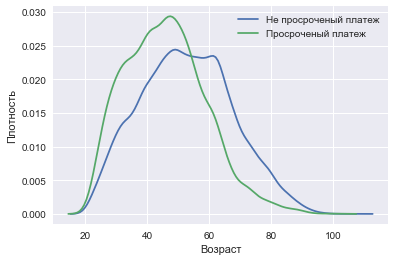

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
import seaborn as sns
%matplotlib inline

data = pd.read_csv('../data/credit_scoring_sample.csv', sep=";")

fig = sns.kdeplot(data.loc[data['SeriousDlqin2yrs'] == 0, 'age'], label = 'Не просроченый платеж')
fig = sns.kdeplot(data.loc[data['SeriousDlqin2yrs'] == 1, 'age'], label = 'Просроченый платеж')        
fig.set(xlabel='Возраст', ylabel='Плотность')    
plt.show()

Как вы уже могли заметить, чем старше клиент банка, тем лучше он платит кредит. Теперь было бы хорошо оценить средний возраст по каждой группе. Так как данных в нашем датасете мало, то искать среднее не совсем правильно, лучше применить наши новые знания бутстрэпа. Давайте сгенерируем 1000 новых подвыборок из нашей генеральной совокупности и сделаем интервальную оценку среднего. 

In [2]:
import numpy as np
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
good_credit = data.loc[data['SeriousDlqin2yrs'] == 0, 'age'].values
bad_credit = data.loc[data['SeriousDlqin2yrs'] == 1, 'age'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
good_credit_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(good_credit, 1000)]
bad_credit_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(bad_credit, 1000)]

#  выводим интервальную оценку среднего
print("Возраст хороших кредитоплательщиков:  mean interval",  stat_intervals(good_credit_mean_scores, 0.05))
print("Возраст плохих кредитоплательщиков:  mean interval",  stat_intervals(bad_credit_mean_scores, 0.05))

Возраст хороших кредитоплательщиков:  mean interval [52.56522391 52.87815666]
Возраст плохих кредитоплательщиков:  mean interval [45.66845452 46.17827149]



В итоге мы получили, что с 95% вероятностью средний возраст лояльных клиентов будет равен примерно 52-53 года, в то время как наши плохие клиенты младше их на 6 лет. 

### Бэггинг


Теперь вы имеете представление о бустрэпе, и мы можем перейти непосредственно к бэггингу. Пусть имеется обучающая выборка $\large X$. С помощью бутстрэпа сгенерируем из неё выборки $\large X_1, \dots, X_M$. Теперь на каждой выборке обучим свой классификатор $\large a_i(x)$. Итоговый классификатор будет усреднять ответы всех этих алгоритмов (в случае классификации это соответствует голосованию): $\large a(x) = \frac{1}{M}\sum_{i = 1}^M a_i(x)$. Эту схему можно представить картинкой ниже.

<img src="../pictures/bagging.png" alt="image"/>

Рассмотрим задачу регрессии с базовыми алгоритмами $\large b_1(x), \dots , b_n(x)$. Предположим, что существует истинная функция ответа для всех объектов $\large y(x)$, а также задано распределение на объектах $\large p(x)$. В этом случае мы можем записать ошибку каждой функции регрессии $$ \large \varepsilon_i(x) = b_i(x) − y(x),  i = 1, \dots, n$$
и записать матожидание среднеквадратичной ошибки $$ \large E_x(b_i(x) − y(x))^{2} = E_x \varepsilon_i (x). $$

Средняя ошибка построенных функций регрессии имеет вид $$ \large E_1 = \frac{1}{n}E_x \sum_{i=1}^n \varepsilon_i^{2}(x) $$

Предположим, что ошибки несмещены и некоррелированы: 

$$ \large \begin{array}{rcl} E_x\varepsilon_i(x) &=& 0, \\
E_x\varepsilon_i(x)\varepsilon_j(x) &=& 0, i \neq j. \end{array}$$

Построим теперь новую функцию регрессии, которая будет усреднять ответы построенных нами функций:
$$ \large a(x) = \frac{1}{n}\sum_{i=1}^{n}b_i(x) $$

Найдем ее среднеквадратичную ошибку:

$$ \large \begin{array}{rcl}E_n &=& E_x\Big(\frac{1}{n}\sum_{i=1}^{n}b_i(x)-y(x)\Big)^2 \\
&=& E_x\Big(\frac{1}{n}\sum_{i=1}^{n}\varepsilon_i\Big)^2 \\
&=& \frac{1}{n^2}E_x\Big(\sum_{i=1}^{n}\varepsilon_i^2(x) + \sum_{i \neq j}\varepsilon_i(x)\varepsilon_j(x)\Big) \\
&=& \frac{1}{n}E_1\end{array}$$

Таким образом, усреднение ответов позволило уменьшить средний квадрат ошибки в n раз!

Напомним вам из нашего предыдущего [урока](https://habrahabr.ru/company/ods/blog/323890/#razlozhenie-oshibki-na-smeschenie-i-razbros-bias-variance-decomposition), как раскладывается общая ошибка:
$$\large \begin{array}{rcl} 
\text{Err}\left(\vec{x}\right) &=& \mathbb{E}\left[\left(y - \hat{f}\left(\vec{x}\right)\right)^2\right] \\
&=& \sigma^2 + f^2 + \text{Var}\left(\hat{f}\right) + \mathbb{E}\left[\hat{f}\right]^2 - 2f\mathbb{E}\left[\hat{f}\right] \\
&=& \left(f - \mathbb{E}\left[\hat{f}\right]\right)^2 + \text{Var}\left(\hat{f}\right) + \sigma^2 \\
&=& \text{Bias}\left(\hat{f}\right)^2 + \text{Var}\left(\hat{f}\right) + \sigma^2
\end{array}$$

Бэггинг позволяет снизить дисперсию (variance) обучаемого классификатора, уменьшая величину, на сколько ошибка будет отличаться, если обучать модель на разных наборах данных, или другими словами, предотвращает переобучение. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными, и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.

В библиотеке `scikit-learn` есть реализация `BaggingRegressor` и `BaggingClassifier`, которая позволяет использовать большинство других алгоритмов "внутри". Рассмотрим на практике как работает бэггинг и сравним его с деревом решений, воспользуясь примером из [документации](http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py).

![image](../pictures/tree_vs_bagging.png)

Ошибка дерева решений
$$ \large 0.0255 (Err) = 0.0003 (Bias^2)  + 0.0152 (Var) + 0.0098 (\sigma^2) $$
Ошибка бэггинга
$$ \large 0.0196 (Err) = 0.0004 (Bias^2)  + 0.0092 (Var) + 0.0098 (\sigma^2) $$

По графику и результатам выше видно, что ошибка дисперсии намного меньше при бэггинге, как мы и доказали теоретически выше. 

Бэггинг эффективен на малых выборках, когда исключение даже малой части обучающих объектов приводит к построению существенно различных базовых классификаторов. В случае больших выборок обычно генерируют подвыборки существенно меньшей длины.

Следует отметить, что рассмотренный нами пример не очень применим на практике, поскольку мы сделали предположение о некоррелированности ошибок, что редко выполняется. Если это предположение неверно, то уменьшение ошибки оказывается не таким значительным. В следующих лекциях мы рассмотрим более сложные методы объединения алгоритмов в композицию, которые позволяют добиться высокого качества в реальных задачах.

### Out-of-bag error

Забегая вперед, отметим, что при использовании случайных лесов нет необходимости в кросс-валидации или в отдельном тестовом наборе, чтобы получить несмещенную оценку ошибки набора тестов. Внутренняя оценка во время работы получается следующим образом:

Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используется при построении k-го дерева.

Это можно легко доказать: пусть в выборке $\large \ell$ объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект — с вероятностью  $\large\frac{1}{\ell}.$ Вероятность того, что объект НЕ попадет в подвыборку (т.е. его не взяли $\large \ell$ раз): $\large (1 - \frac{1}{\ell})^\ell$. При $\large \ell \rightarrow +\infty$ получаем один из "замечательных" пределов $\large \frac{1}{e}$. Тогда вероятность попадания конкретного объекта в подвыборку $\large \approx  1 - \frac{1}{e} \approx 63\%$.

Давайте рассмотрим, как это работает на практике:

![image](../pictures/oob.png)
На рисунке видно, что наш классификатор ошибся в 4 наблюдениях, которые мы не использовали для тренировки. Значит точность нашего классификатора: $\large \frac{11}{15}*100\% = 73.33\%$

Получается, что каждый базовый алгоритм обучается на ~63% исходных объектов. Значит, на оставшихся ~37% его можно сразу проверять. Out-of-Bag оценка — это усредненная оценка базовых алгоритмов на тех ~37% данных, на которых они не обучались.

In [3]:
import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')
pp.ProfileReport(data)

/usr/local/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/Cellar/python/3.6.4_3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.4_3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/s

Number of variables,8
Number of observations,45063
Total Missing (%),2.7%
Total size in memory,2.8 MiB
Average record size in memory,64.0 B
Numeric,5
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,2


In [4]:
y = data["SeriousDlqin2yrs"].astype(int)
X = data.drop(["SeriousDlqin2yrs"], axis=1)

In [5]:
X.isnull().mean()

age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
NumberOfTimes90DaysLate                 0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
MonthlyIncome                           0.191798
NumberOfDependents                      0.024788
dtype: float64

In [6]:
X = X.fillna(X.median())

In [7]:
X.isnull().mean()

age                                     0.0
NumberOfTime30-59DaysPastDueNotWorse    0.0
DebtRatio                               0.0
NumberOfTimes90DaysLate                 0.0
NumberOfTime60-89DaysPastDueNotWorse    0.0
MonthlyIncome                           0.0
NumberOfDependents                      0.0
dtype: float64

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


In [9]:
skf = StratifiedKFold(shuffle=True, random_state=42)

In [10]:
lg = LogisticRegression(class_weight= 'balanced')
parameters = {"C": [0.0001, 0.005, 0.001, 0.01, 1]}
r_grid_search = RandomizedSearchCV(lg, parameters, scoring ='roc_auc', n_iter=5, cv=skf, random_state=1)
r_grid_search = r_grid_search.fit(X, y)
print(r_grid_search.best_score_)

0.795295806551566


In [11]:
parameters = {'max_features': [0.5, 0.7, 0.9, 1.], 'max_samples': [0.5, 0.7, 0.9, 1.], "base_estimator__C": [0.005, 0.001, 0.01]}
bg = BaggingClassifier(lg, random_state=42, n_estimators=25)
r_grid_search = RandomizedSearchCV(bg, parameters, scoring ='roc_auc', n_iter=10, cv=skf, random_state=1)
r_grid_search = r_grid_search.fit(X, y)
print(r_grid_search.best_score_)

0.8043960093687058


In [12]:
r_grid_search.best_params_

{'base_estimator__C': 0.005, 'max_features': 0.5, 'max_samples': 0.9}